<a href="https://colab.research.google.com/github/JacoDuToit11/NLPProjects/blob/master/CovidTweetsClassifier/CovidTweetsClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import Adam

In [26]:
model_name = 'prajjwal1/bert-mini'
num_classes = 5

In [27]:
class CustomDataset(Dataset):
  def __init__(self, dataframe, num_classes):
        self.data = dataframe
        self.num_classes = num_classes
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.max_length = 256

        self.label_encoder = LabelEncoder()
        self.one_hot_encoder = OneHotEncoder(sparse=False)

        # Fit the label encoder to the unique label names
        self.label_encoder.fit(dataframe['Sentiment'])

  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):
      text = self.data.iloc[idx]['OriginalTweet']
      label_name = self.data.iloc[idx]['Sentiment']

      # Tokenize the text
      inputs = self.tokenizer(text, max_length=self.max_length, truncation=True, padding='max_length', return_tensors='pt')

      label_numeric = self.label_encoder.transform([label_name])[0]
      # label_one_hot = torch.nn.functional.one_hot(torch.tensor(label_numeric), num_classes=self.num_classes).squeeze()

      return {'input_ids': inputs['input_ids'].squeeze(),
                'attention_mask': inputs['attention_mask'].squeeze(),
                'label': label_numeric}

In [28]:
def create_dataset(folder_name):
  training_folder_path = "/content/drive/MyDrive/NLP Datasets/CovidTweetsData/" + folder_name
  df = pd.read_csv(training_folder_path, encoding='latin1')
  # Drop unnessecary columns
  columns_to_drop = ['UserName', 'ScreenName', 'Location', 'TweetAt']
  df.drop(columns=columns_to_drop, inplace=True)
  print(df.head())
  # Get class distribution.
  df.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
  plt.gca().spines[['top', 'right',]].set_visible(False)

  return CustomDataset(df, num_classes)

                                       OriginalTweet           Sentiment
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral
1  advice Talk to your neighbours family to excha...            Positive
2  Coronavirus Australia: Woolworths to give elde...            Positive
3  My food stock is not the only one which is emp...            Positive
4  Me, ready to go at supermarket during the #COV...  Extremely Negative


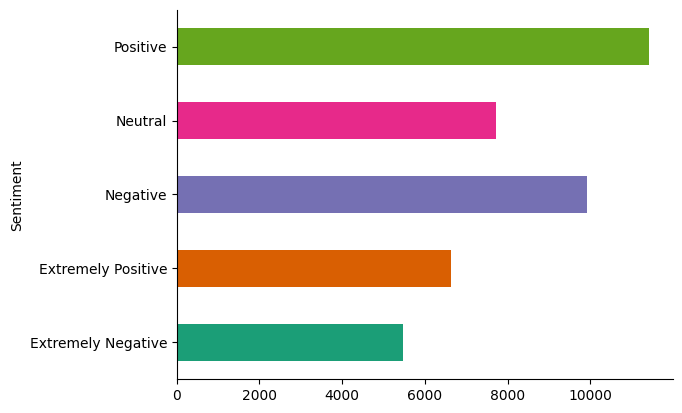

In [29]:
train_dataset = create_dataset("Corona_NLP_train.csv")

In [30]:
train_dataset[0]

{'input_ids': tensor([  101,  1030,  2273, 12541, 11283,  1030,  6316,  1035, 11721,  4819,
          1030,  3782,  4183,  2615, 16770,  1024,  1013,  1013,  1056,  1012,
          2522,  1013,  2065,  2480,  2683, 15143,  2475,  4502,  1998, 16770,
          1024,  1013,  1013,  1056,  1012,  2522,  1013, 22038,  2575,  5603,
         25708,  2480,  9468,  1998, 16770,  1024,  1013,  1013,  1056,  1012,
          2522,  1013,  1045,  2475, 20554, 26494,  2595,  3630,  2620,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

                                       OriginalTweet           Sentiment
0  TRENDING: New Yorkers encounter empty supermar...  Extremely Negative
1  When I couldn't find hand sanitizer at Fred Me...            Positive
2  Find out how you can protect yourself and love...  Extremely Positive
3  #Panic buying hits #NewYork City as anxious sh...            Negative
4  #toiletpaper #dunnypaper #coronavirus #coronav...             Neutral


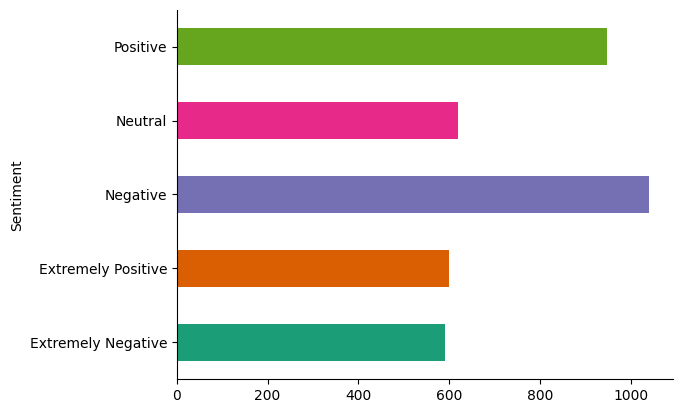

In [31]:
test_dataset = create_dataset("Corona_NLP_test.csv")

In [32]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [33]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-mini and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, e

In [35]:
num_epochs = 2
optimizer = Adam(model.parameters(), lr=1e-5)

for epoch in range(num_epochs):
  total_loss = 0.0
  progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')

  for batch_idx, batch in enumerate(train_loader):
    if batch_idx >= 5:
          break
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

    progress_bar.set_postfix({'Training Loss': total_loss / len(train_loader)})


Epoch 1/2:   0%|          | 0/2573 [07:10<?, ?it/s, Training Loss=0.0875]

Epoch 2/2:   0%|          | 0/2573 [00:10<?, ?it/s, Training Loss=0.00302]